### Introduction

In [61]:
import os
import json
from stable_baselines3 import PPO
from sb3_contrib import MaskablePPO
from utils.utils_train import get_agent, get_action_mask
from envs.multi_eqn_curriculum import multiEqn
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.common.wrappers import ActionMasker
import matplotlib.pyplot as plt


# Define model path
agent_type = 'ppo-mask'
level = 7
nlayer = 3
save_dir = f'data/curriculum/random/level{level}/{agent_type}/n_layer{nlayer}'
model_path = os.path.join(save_dir, f"{agent_type}_trained_model")

# Load saved arguments
args_path = os.path.join(save_dir, "args.json")
if not os.path.exists(args_path):
    raise FileNotFoundError(f"Could not find args.json at {args_path}")

with open(args_path, "r") as f:
    args = json.load(f)

print(f"Loaded training arguments from {args_path}")

# Recreate the environment with saved parameters
env = multiEqn(
    state_rep=args['state_rep'], 
    normalize_rewards=args['normalize_rewards'], 
    level=args['level'], 
    generalization=args['generalization']
)
if agent_type in ["ppo-mask",'ppo-cnn','ppo-gnn','ppo-gnn1']:
    env = ActionMasker(env, get_action_mask)
env = DummyVecEnv([lambda: Monitor(env)])

# Load the trained model
sb3_kwargs = {
    "ent_coef": args['ent_coef'],
    "n_steps": args['n_steps'],
    "batch_size": args['batch_size'],
    "n_epochs": args['n_epochs'],
    "gamma": args['gamma'],
    "gae_lambda": args['gae_lambda'],
    "vf_coef": args['vf_coef'],
    "clip_range": args['clip_range'],
    "max_grad_norm": args['max_grad_norm'],
}

agent = get_agent(args['agent_type'], env, **sb3_kwargs)
agent = agent.load(model_path, env=env)

print(f"Successfully loaded model from {model_path}")

Loaded training arguments from data/curriculum/random/level7/ppo-mask/n_layer3/args.json
Successfully loaded model from data/curriculum/random/level7/ppo-mask/n_layer3/ppo-mask_trained_model


Eqn: a*x
obs = [ 1  5  1 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26  0 17 26 26
 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26]
latent_rep = [[ 1.  5.  1. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26.
  26. 26.  0. 17. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26.
  26. 26. 26. 26. 26.]]


/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.lhs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.lhs` for environment variables or `env.get_wrapper_attr('lhs')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment varia

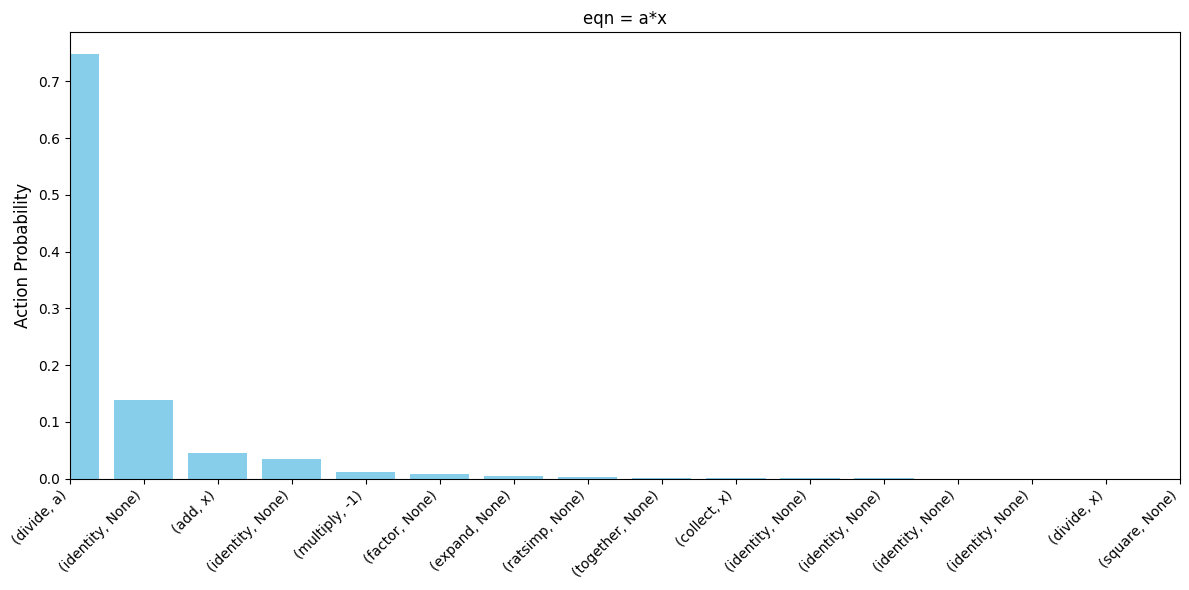

In [64]:
import torch as th
from sympy import sympify
import matplotlib.pyplot as plt
import numpy as np
from utils.custom_functions import operation_names


# Define the equation to evaluate (single equation)
# eqn = sympify('ax+b')
# print(f"Evaluating equation: {eqn}")

# Reset environment (using options if needed)
obs = env.reset()
# env.env_method('set_equation', eqn)
obs = env.envs[0].state
print(f'Eqn: {env.envs[0].lhs}')
print(f'obs = {obs}')

# Lists to store the action probabilities and latent representations for this episode.
episode_action_probs = []
episode_latent_reps = []

# Convert observation (a regular numpy array) to a PyTorch tensor.
obs_tensor = th.tensor(obs, dtype=th.float32)
# Ensure a batch dimension is present.
if obs_tensor.ndim < 2:
    obs_tensor = obs_tensor.unsqueeze(0)

# Get the policy distribution and latent representation.
distribution = agent.policy.get_distribution(obs_tensor)
action_probs = distribution.distribution.probs.detach().cpu().numpy()
latent_rep = agent.policy.features_extractor(obs_tensor).detach().cpu().numpy()
print(f'latent_rep = {latent_rep}')

# Assuming action_probs is a numpy array of shape (1, action_dim)
action_prob = action_probs[0]  # Remove the batch dimension

# Get the actual actions from the underlying environment (as tuples)
actions_actual = env.envs[0].actions  # e.g., list of tuples (operation, term)
# Map each action to a string label using operation_names for the operation.
action_labels = [f"({operation_names[op]}, {term})" for op, term in actions_actual]

# Ensure that the number of labels matches the number of probabilities
if len(action_labels) != len(action_prob):
    raise ValueError("Mismatch between number of actions and probabilities.")

# Sort the indices in descending order based on probabilities.
sorted_indices = np.argsort(action_prob)[::-1]
sorted_probs = action_prob[sorted_indices]
sorted_labels = [action_labels[i] for i in sorted_indices]

# Create a bar chart.
x = np.arange(len(sorted_probs))
plt.figure(figsize=(12, 6))
plt.bar(x, sorted_probs, color='skyblue')
plt.xticks(x, sorted_labels, rotation=45, ha='right')
plt.xlim([0, 30])  # adjust as needed
plt.ylabel("Action Probability")
plt.title(f"eqn = {env.envs[0].main_eqn}")
plt.xlim([0,15])
plt.tight_layout()
plt.show()


In [70]:
import torch as th
from sympy import sympify
import matplotlib.pyplot as plt
import numpy as np
from utils.custom_functions import operation_names


latent_reps = set()
for _ in range(100):

    # Define the equation to evaluate (single equation)
    # eqn = sympify('ax+b')
    # print(f"Evaluating equation: {eqn}")

    # Reset environment (using options if needed)
    obs = env.reset()
    # env.env_method('set_equation', eqn)
    obs = env.envs[0].state
    print(f'Eqn: {env.envs[0].lhs}')
    print(f'obs = {obs}')

    # Lists to store the action probabilities and latent representations for this episode.
    episode_action_probs = []
    episode_latent_reps = []

    # Convert observation (a regular numpy array) to a PyTorch tensor.
    obs_tensor = th.tensor(obs, dtype=th.float32)
    # Ensure a batch dimension is present.
    if obs_tensor.ndim < 2:
        obs_tensor = obs_tensor.unsqueeze(0)

    # Get the policy distribution and latent representation.
    distribution = agent.policy.get_distribution(obs_tensor)
    action_probs = distribution.distribution.probs.detach().cpu().numpy()
    latent_rep = agent.policy.features_extractor(obs_tensor).detach().cpu().numpy()
    print(f'latent_rep = {latent_rep}')


    features = agent.policy.features_extractor(obs_tensor)
    latent_rep_full = agent.policy.mlp_extractor.forward_actor(features).detach().cpu().numpy()
    print("Latent representation (from actor network):", latent_rep_full)

    latent_reps.add(latent_rep_full)

latent_reps

Eqn: a*x
obs = [ 1  5  1 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26  0 17 26 26
 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26]
latent_rep = [[ 1.  5.  1. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26.
  26. 26.  0. 17. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26. 26.
  26. 26. 26. 26. 26.]]
Latent representation (from actor network): [[ 0.09000008  0.99977964 -0.9999998   0.9998763  -0.99575585  0.99555004
  -0.1699341   0.9920455   0.6791497  -0.9863882   0.70572084 -1.
  -0.9875743  -0.99999404 -0.99995106  0.99986565 -0.99999994 -0.99999994
   0.947922    1.         -0.35710144 -0.99999875 -0.97894394 -0.9635567
   0.6878246   0.99995565  1.          1.         -0.9992115  -0.99999297
  -0.92239386 -0.9999999   0.9999343  -0.9999927  -0.99993414 -0.70487285
   0.99999315 -0.9996512   0.9998692  -0.9527353   0.9755788   0.20134754
  -0.9936999  -0.8611902  -0.9805386  -1.         -1.         -0.99913305
   0.26900414  0.9938277   0.99971277  1.      

/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.lhs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.lhs` for environment variables or `env.get_wrapper_attr('lhs')` that will search the reminding wrappers.
  logger.warn(


TypeError: unhashable type: 'numpy.ndarray'

/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.lhs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.lhs` for environment variables or `env.get_wrapper_attr('lhs')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.main_eqn to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.main_eqn` for environment var

Eqn: c + d/(a*x + b)
obs = [-1 10  1  4  0 -1  9  1  5  1 26 26 26 26 26 26 26 26 26 26  0 17 26 26
 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26]
Latent representation (from actor network): [[ 0.99999523  0.75160336 -0.99999994 -0.9952994  -0.999997    0.9316121
  -0.98648685  0.9999893   1.          0.997587    0.9999022  -0.9999532
  -0.99849015 -0.9999999   0.4967429   0.999924   -0.99999595 -0.99999124
   0.9998373   0.9999953   0.96282977 -0.9999999  -0.87174     0.95088714
  -0.9958413   0.96463114  1.          1.          0.9909567  -0.9999999
  -0.7135696  -0.6917364   0.9999067  -1.         -0.99385315  0.9999954
   0.99999994 -1.          0.9983287   0.9936216   0.999998   -0.20736615
  -0.99994427 -0.48525962 -0.9921616  -1.         -1.         -0.9925458
  -0.9507459  -0.99990004  0.99998367  1.         -0.9975425  -0.99881583
   0.99999994 -0.9999982   0.9999999  -0.99647224  0.9999997   0.999826
  -0.99716526  1.          0.99802995 -1.          1.         -1.
  -0

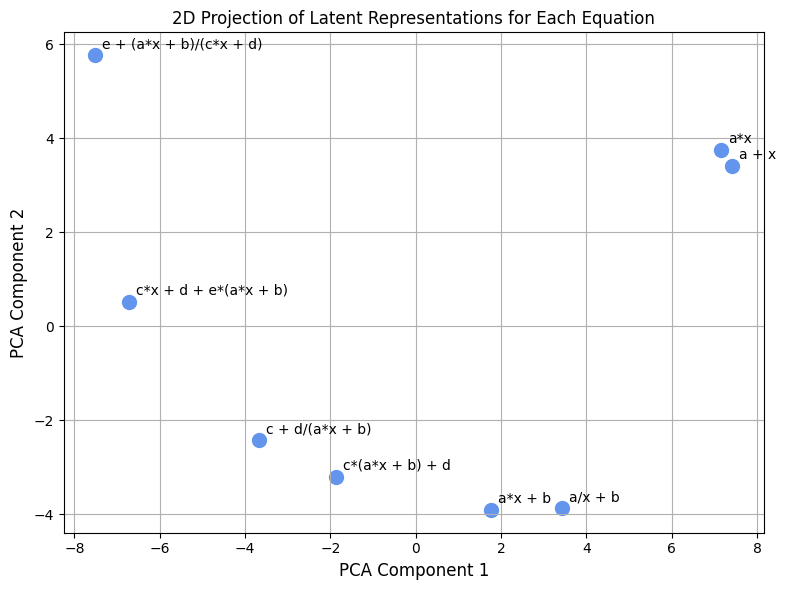

In [84]:
import torch as th
from sympy import sympify
import matplotlib.pyplot as plt
import numpy as np
from utils.custom_functions import operation_names
from sklearn.decomposition import PCA

# Collect latent representations
latent_reps = []  # List to store latent representations

# Collect representations over 100 episodes (or resets)
latent_reps = {}
for _ in range(100):
    # Reset environment and get the current state from the underlying environment.
    obs = env.reset()
    obs = env.envs[0].state
    print(f'Eqn: {env.envs[0].lhs}')
    print(f'obs = {obs}')
    
    # Convert observation (assumed to be a numpy array) to a PyTorch tensor.
    obs_tensor = th.tensor(obs, dtype=th.float32)
    if obs_tensor.ndim < 2:
        obs_tensor = obs_tensor.unsqueeze(0)
    
    # Extract features and then the latent representation using the actor network.
    features = agent.policy.features_extractor(obs_tensor)
    latent_rep_full = agent.policy.mlp_extractor.forward_actor(features).detach().cpu().numpy()
    print("Latent representation (from actor network):", latent_rep_full)
    
    # Remove the batch dimension and append the latent vector.
    if env.envs[0].main_eqn not in latent_reps:
        latent_reps[env.envs[0].main_eqn] = latent_rep_full[0]


# Plot
# Assume latent_reps is a dict: { eqn_str: latent_vector, ... }
# First, convert the dictionary into a matrix and a list of labels.
labels = list(latent_reps.keys())
latent_values = np.stack([latent_reps[eqn] for eqn in labels])  # shape: (n_equations, latent_dim)

# Use PCA to project the latent representations to 2D.
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_values)

# Plot the 2D projection with annotations.
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=100, color='cornflowerblue')

for i, label in enumerate(labels):
    plt.annotate(label, (latent_2d[i, 0], latent_2d[i, 1]),
                 textcoords="offset points", xytext=(5,5), ha='left', fontsize=10)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Projection of Latent Representations for Each Equation")
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.to_vec to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.to_vec` for environment variables or `env.get_wrapper_attr('to_vec')` that will search the reminding wrappers.
  logger.warn(


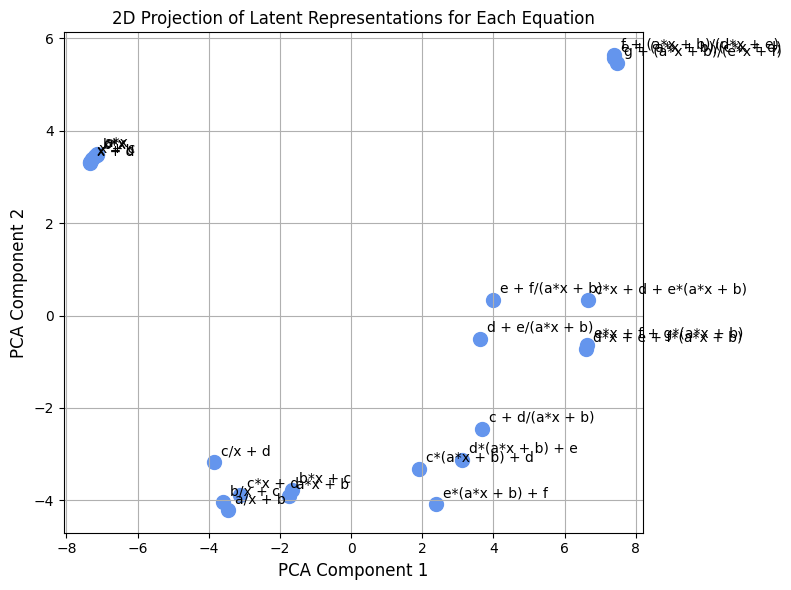

In [118]:
import torch as th
from sympy import sympify
import matplotlib.pyplot as plt
import numpy as np
from utils.custom_functions import operation_names
from sklearn.decomposition import PCA

# Example set of equations
base_eqns = [
    # Row 1: Multiplication
    "a*x", "b*x", "c*x",
    # Row 2: Addition
    "x + b", "x + c", "x + d",
    # Row 3: Linear equations
    "a*x + b", "b*x + c", "c*x + d",
    # Row 4: Reciprocal form
    "a/x + b", "b/x + c", "c/x + d",
    # Row 5: Scaled linear combination
    "c*(a*x + b) + d", "d*(a*x + b) + e", "e*(a*x + b) + f",
    # Row 6: Rational combination (with division)
    "c + d/(a*x + b)", "d + e/(a*x + b)", "e + f/(a*x + b)",
    # Row 7: Additive and multiplicative mix
    "c*x + d + e*(a*x + b)", "d*x + e + f*(a*x + b)", "e*x + f + g*(a*x + b)",
    # Row 8: Compound rational equation
    "e + (a*x + b)/(c*x + d)", "f + (a*x + b)/(d*x + e)", "g + (a*x + b)/(e*x + f)"
]

# Dictionary to hold { equation_string : latent_vector }
latent_reps = {}

for eqn_str in base_eqns:
    eqn = sympify(eqn_str)
    
    # 1) Reset environment, convert eqn -> vector
    obs = env.reset()
    # Your 'to_vec' method presumably returns (observation, done_flag). 
    # We'll ignore the done_flag if it exists.
    obs, _ = env.envs[0].to_vec(eqn, 0)
    
    # 2) Convert numpy array -> PyTorch tensor
    obs_tensor = th.tensor(obs, dtype=th.float32)
    if obs_tensor.ndim < 2:
        obs_tensor = obs_tensor.unsqueeze(0)
    
    # 3) Extract features from the policy's feature extractor
    features = agent.policy.features_extractor(obs_tensor)
    
    # 4) Get the actor network output. 
    #    This might come out with shape (1, latent_dim)
    latent_rep_full = agent.policy.mlp_extractor.forward_actor(features).detach().cpu().numpy()
    
    # 5) Squeeze away any singleton dimension so we get shape (latent_dim,)
    latent_rep_squeezed = np.squeeze(latent_rep_full)
    
    # 6) Store in the dictionary
    latent_reps[eqn_str] = latent_rep_squeezed

# --- Now we do a PCA plot on these latent vectors ---

# Convert dict to lists
labels = list(latent_reps.keys())
latent_values = np.stack([latent_reps[eqn] for eqn in labels])  
# shape is now (n_equations, latent_dim)

# 7) PCA to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_values)

# 8) Plot
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=100, color='cornflowerblue')

for i, label in enumerate(labels):
    plt.annotate(
        label,
        (latent_2d[i, 0], latent_2d[i, 1]),
        textcoords="offset points",
        xytext=(5,5),
        ha='left',
        fontsize=10
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D Projection of Latent Representations for Each Equation")
plt.grid(True)
plt.tight_layout()
plt.show()

/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.set_equation to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.set_equation` for environment variables or `env.get_wrapper_attr('set_equation')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.to_vec to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.to_vec` for environment variables or `env.get_wrapper_attr('to_vec')` that will search the reminding wrappers.
  logger.warn(
/Users/Kev/mambaforge/envs/abel-rl/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.lhs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.lhs`

Cosine similarity between (a*x+b) - (a*x) and (x+b) - (x): -0.2277


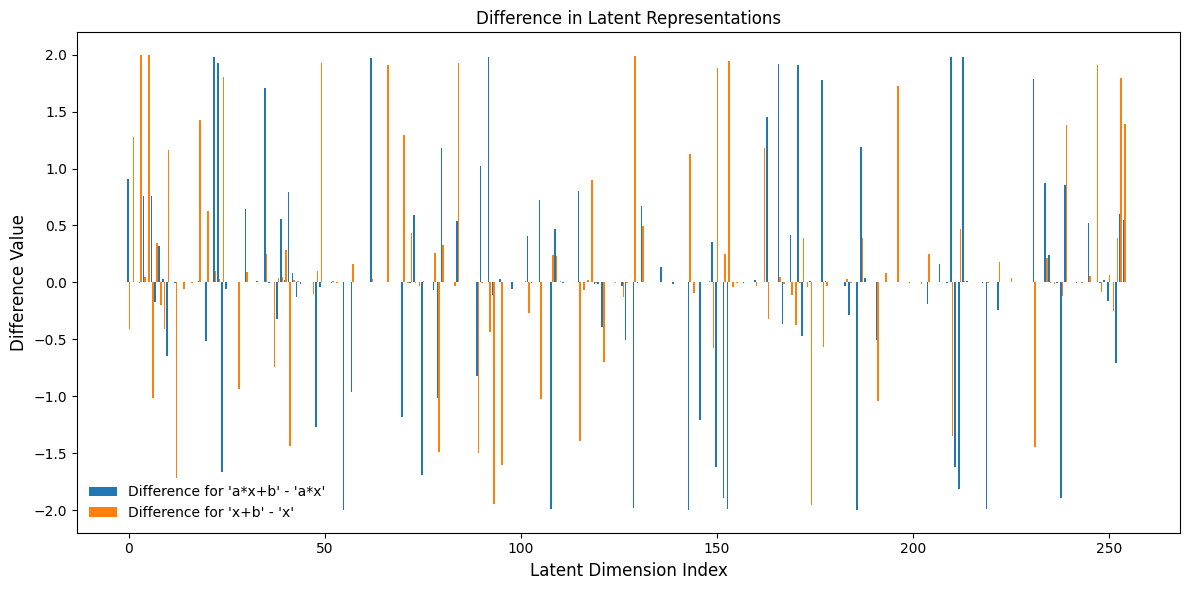

In [122]:
import torch as th
from sympy import sympify
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_latent(eq_str):
    """Reset the environment with the given equation and extract the latent representation from the actor network."""
    eqn = sympify(eq_str)
    obs = env.reset()
    env.envs[0].set_equation(eqn)
    obs, _ = env.envs[0].to_vec(env.envs[0].lhs, env.envs[0].rhs)
    obs_tensor = th.tensor(obs, dtype=th.float32)
    if obs_tensor.ndim < 2:
        obs_tensor = obs_tensor.unsqueeze(0)
    features = agent.policy.features_extractor(obs_tensor)
    latent = agent.policy.mlp_extractor.forward_actor(features).detach().cpu().numpy()[0]
    return latent

# Define some equation pairs
eq_base1 = "a*x"         # base
eq_const1 = "a*x+b"      # base with constant

eq_base2 = "x"           # another base
eq_const2 = "x+b"        # base with constant

# Extract latent representations
latent_base1 = get_latent(eq_base1)
latent_const1 = get_latent(eq_const1)
latent_base2 = get_latent(eq_base2)
latent_const2 = get_latent(eq_const2)

# Compute difference vectors
diff1 = latent_const1 - latent_base1
diff2 = latent_const2 - latent_base2

# Compute cosine similarity between the difference vectors
cos_sim = cosine_similarity(diff1.reshape(1, -1), diff2.reshape(1, -1))[0][0]
print(f"Cosine similarity between (a*x+b) - (a*x) and (x+b) - (x): {cos_sim:.4f}")

# You might also plot these difference vectors side by side (e.g., as bar charts):
import matplotlib.pyplot as plt

x_axis = np.arange(len(diff1))
plt.figure(figsize=(12, 6))
plt.bar(x_axis - 0.2, diff1, width=0.4, label=f"Difference for '{eq_const1}' - '{eq_base1}'")
plt.bar(x_axis + 0.2, diff2, width=0.4, label=f"Difference for '{eq_const2}' - '{eq_base2}'")
plt.xlabel("Latent Dimension Index")
plt.ylabel("Difference Value")
plt.title("Difference in Latent Representations")
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
2+4

6